1. Setup and Load Data

1.1 Install Dependencies and Define Hyperparameters

In [1]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary
import tqdm
import math

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 400
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are successfully using a GPU, this print should contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


1.2 Load Data

In [2]:
# change directory to the data directory
os.chdir('../HMEI2023-bxliu-data/')

# initialize the lists that store the images and thetas
image_list = []
theta_list = []

# name of directories of the images and values
image_directory = 'image_5by400'
value_directory = 'value_5by400'

# iterate over files in image directory
for filename in tqdm.tqdm(os.listdir(image_directory)):
    f = os.path.join(image_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # load the image data
        # use this for color images (3 channels)
        # image = Image.open(f)
        # data = np.asarray(image)

        # use this for gray scale images (1 channel)
        data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
        data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
        data = np.expand_dims(data, axis=2)

        # load the theta data
        matfile = value_directory + '/' + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)

        # append to the image and theta lists
        image_list.append(data)
        x = mat['th0'][0]
        # x[0] = math.log(x[0])
        theta_list.append(x)

# reformat the lists to make the compatable with what we want to do in Pytorch
theta_list = np.asarray(theta_list)
image_list = np.asarray(image_list)

print(theta_list[0])

image_list = np.moveaxis(image_list, -1, 1)

image_list = torch.tensor(image_list).float()

theta_list = torch.tensor(theta_list)

os.chdir('../HMEI2023-bxliu/')

100%|██████████| 10000/10000 [01:28<00:00, 113.16it/s]


[1.e+00 5.e-01 5.e+03]


1.3 Normalize Data

In [3]:
# images
imean = torch.std(image_list, dim=0)
istd = torch.mean(image_list, dim=0)
image_tensor = torch.div(image_list, 255).float()
# print(image_tensor)

# theta
tmean = torch.mean(theta_list, dim=0)
tstd = torch.std(theta_list, dim=0)
tstd[0] = 1
theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
# print(theta_tensor)

1.4 Make Dataset and DataLoaders

In [4]:
full_dataset = TensorDataset(image_tensor, theta_tensor)

# split data into training, validation, and testing data
train, val, test = torch.utils.data.random_split(full_dataset, [0.75, 0.125, 0.125])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=42, shuffle=False)
test_loader = DataLoader(test, batch_size=2, shuffle=False)

In [5]:
print(train_loader)
print(val_loader)
print(test_loader)

2. Set Up the Convolution Neural Network

2.1 Make Network

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 128*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) 
            x = self.pool2(F.relu(self.conv2(x))) 
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x)) 
            x = self.fc3(x)
            return x

In [7]:
# Check if CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 1 channel, 128-by-128
    test_data = torch.rand(100,1,128,128)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out.size())
    assert(out.size()==(100,3))

torch.Size([100, 3])


2.2 Make Trainer for Training Network

In [8]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None, val_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train(self,epochs):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            epoch_train_loss = 0.0
            epoch_val_loss = 0.0
            epoch_train_steps = 0
            epoch_val_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,1,128,128) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
   
                # Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # Getting the output of the Network
                out = self.net(X)

                # Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # Backpropagate to compute gradients of parameteres
                loss.backward()

                # Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_train_loss += loss.item()
                epoch_train_steps += 1
            
            # validation
            self.net.eval()
            for data in val_loader:
                X = data[0].to(device)
                y = data[1].to(device)
        
                out = self.net(X)
                loss = self.loss_function(out, y)
                epoch_val_loss += loss.item()
                epoch_val_steps += 1

            # average loss of epoch
            train_losses.append(epoch_train_loss / epoch_train_steps)
            print("epoch [%d]: train loss %.3f" % (epoch+1, train_losses[-1]))
            val_losses.append(epoch_val_loss / epoch_val_steps)
            print("epoch [%d]: val loss %.3f" % (epoch+1, val_losses[-1]))
        # return train_losses
        return train_losses, val_losses

3. Train and Evaluate Network

3.1 Train Network

In [9]:
#try different learning rates to see which one works 
learning_rate = 0.00001 # only nu, only sigma, color, gray, constant nu?, constant rho?, constant sigma?, rand 10 by 200
# learning_rate = 0.0001 # only rho
# learning_rate = 0.0000001 # 5 by 400
# learning_rate = 0.000001 # 10 by 200, rand 5 by 400

net = ConvNet()
net = net.to(device)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader)

train_losses, val_losses = trainer.train(num_epochs)


epoch [1]: train loss 0.659
epoch [1]: val loss 0.655
epoch [2]: train loss 0.640
epoch [2]: val loss 0.623
epoch [3]: train loss 0.592
epoch [3]: val loss 0.561
epoch [4]: train loss 0.513
epoch [4]: val loss 0.475
epoch [5]: train loss 0.428
epoch [5]: val loss 0.396
epoch [6]: train loss 0.381
epoch [6]: val loss 0.375
epoch [7]: train loss 0.371
epoch [7]: val loss 0.371
epoch [8]: train loss 0.368
epoch [8]: val loss 0.369
epoch [9]: train loss 0.365
epoch [9]: val loss 0.366
epoch [10]: train loss 0.363
epoch [10]: val loss 0.364
epoch [11]: train loss 0.360
epoch [11]: val loss 0.361
epoch [12]: train loss 0.358
epoch [12]: val loss 0.359
epoch [13]: train loss 0.355
epoch [13]: val loss 0.357
epoch [14]: train loss 0.353
epoch [14]: val loss 0.355
epoch [15]: train loss 0.351
epoch [15]: val loss 0.353
epoch [16]: train loss 0.349
epoch [16]: val loss 0.351
epoch [17]: train loss 0.347
epoch [17]: val loss 0.349
epoch [18]: train loss 0.344
epoch [18]: val loss 0.346
epoch [19]

3.2 Plot losses

Text(0, 0.5, 'training loss')

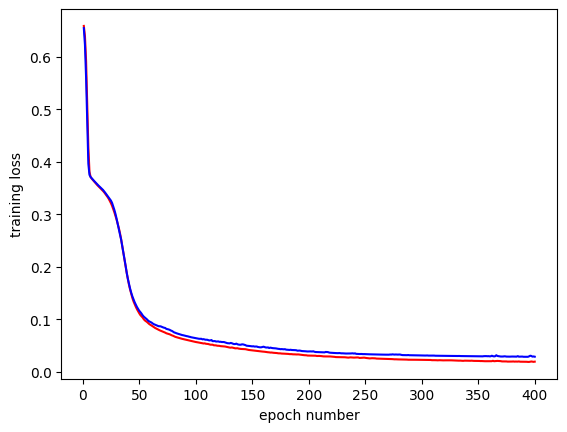

In [10]:
import matplotlib.pyplot as plt
# plot the training loss (y-axis) vs epoch number (x-axis) using the losses computed
plt.plot(range(1,num_epochs+1), train_losses, color = 'red')
plt.plot(range(1,num_epochs+1), val_losses, color = 'blue')
plt.xlabel("epoch number")
plt.ylabel("training loss")

3.3 Test Network

In [11]:
# keep track of all losses and outputs
hist_array = []
out_array = []

# errors for th0(1), th0(2), th0(3) respectively
err1 = 0
err2 = 0
err3 = 0
tot = 0
count = 0
with torch.no_grad():
    for data in test_loader:
        # retrieve X and y for this batch, from data, and 
        # move it to the device you are using (probably the GPU)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)

        a = torch.add(torch.mul(output[0], tstd.to(device)), tmean.to(device))
        b = torch.add(torch.mul(y[0], tstd.to(device)), tmean.to(device))

        print("###################################################")
        print(a)
        print(b)
        print("###################################################")

        hist_array.append(a.cpu().numpy() - b.cpu().numpy())
        out_array.append(a.cpu().numpy())
        
        tot += y.size(0)

        errors = output.sub(y).multiply(output.sub(y)).div(2).sum(axis=0)
        err1 += errors[0]
        err2 += errors[1]
        err3 += errors[2]
        count += 1

print(tot)
print(err1/count)
print(err2/count)
print(err3/count)

print('Accuracy of prediction on test (1): %5.2f%%' % (100-100 * err1 / tot))

print('Accuracy of prediction on test (2): %5.2f%%' % (100-100 * err2 / tot))

print('Accuracy of prediction on test (3): %5.2f%%' % (100-100 * err3 / tot))

###################################################
tensor([9.7397e-01, 8.6249e-01, 1.2246e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([9.9716e-01, 1.3843e+00, 2.2062e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000e+00, 1.5000e+00, 2.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([9.9686e-01, 5.1101e-01, 1.9424e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000e+00, 5.0000e-01, 2.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([9.8891e-01, 9.2116e-01, 2.5130e+04], device='cuda:0',
       dtype=torch.float64)
tensor

3.4 Plot Histograms of Losses and Outputs

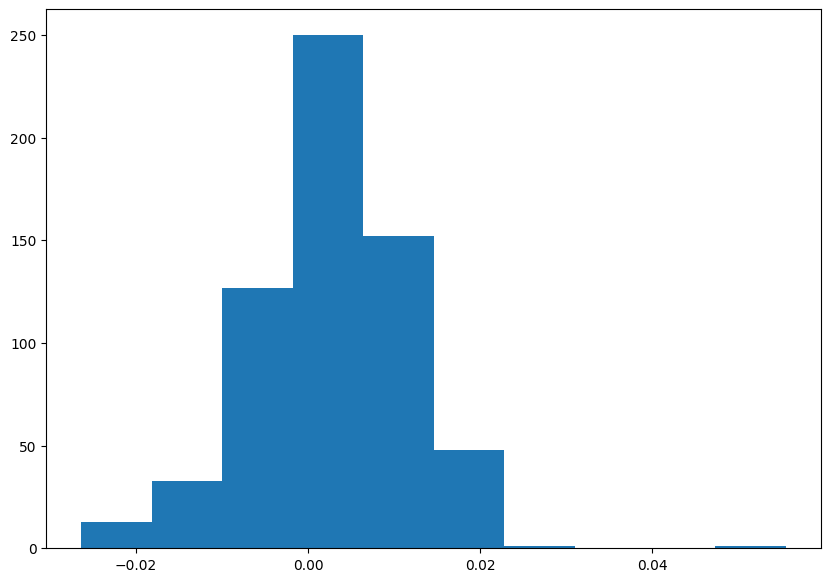

In [12]:
hist_array = np.array(hist_array)
a = hist_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

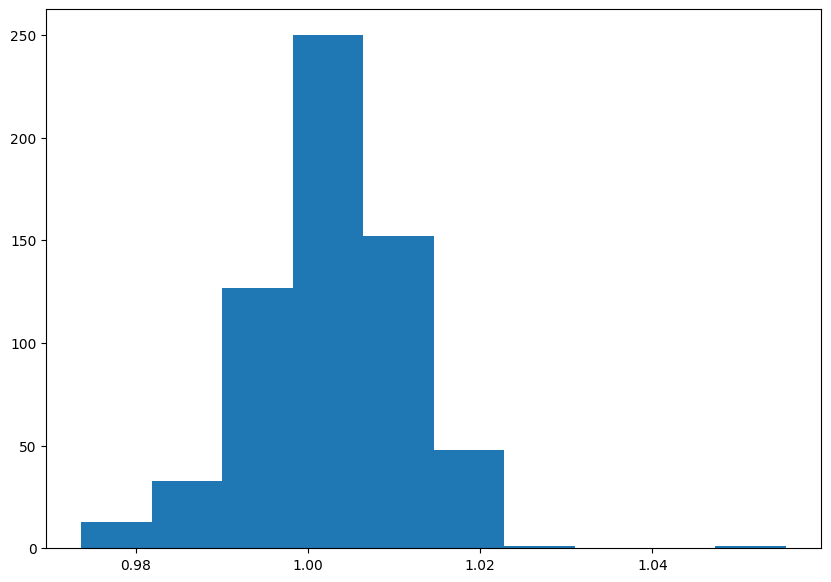

In [13]:
out_array = np.array(out_array)
a = out_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

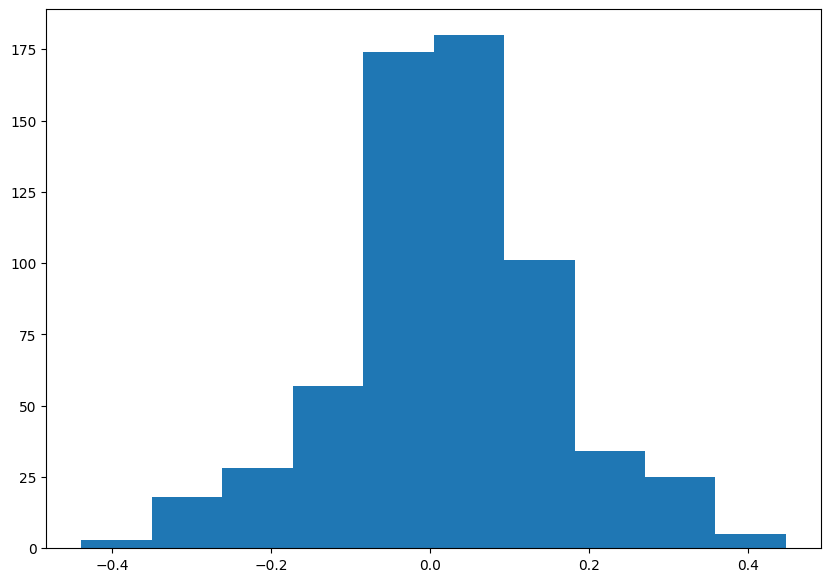

In [14]:
a = hist_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

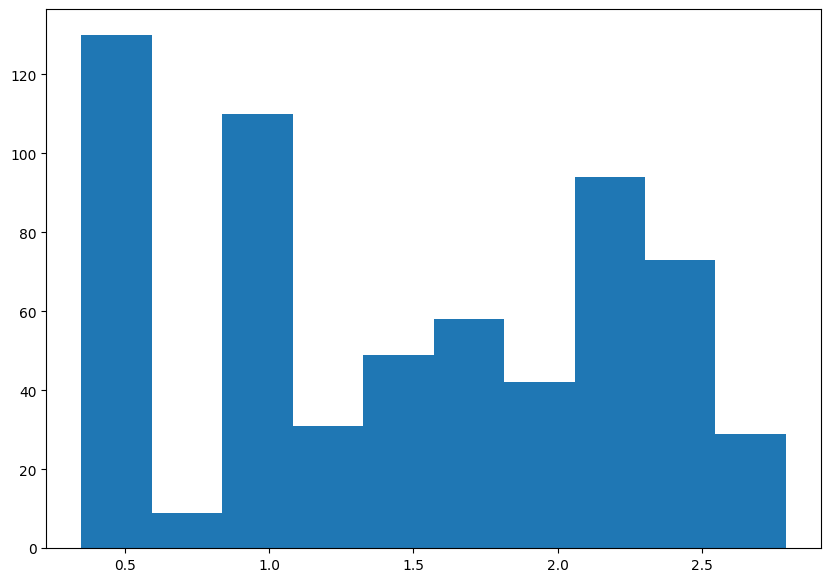

In [15]:
a = out_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

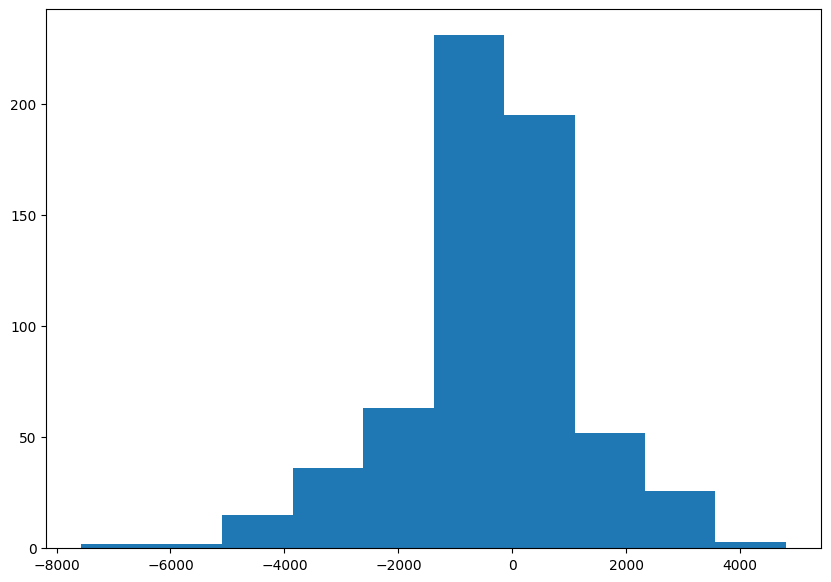

In [16]:
a = hist_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

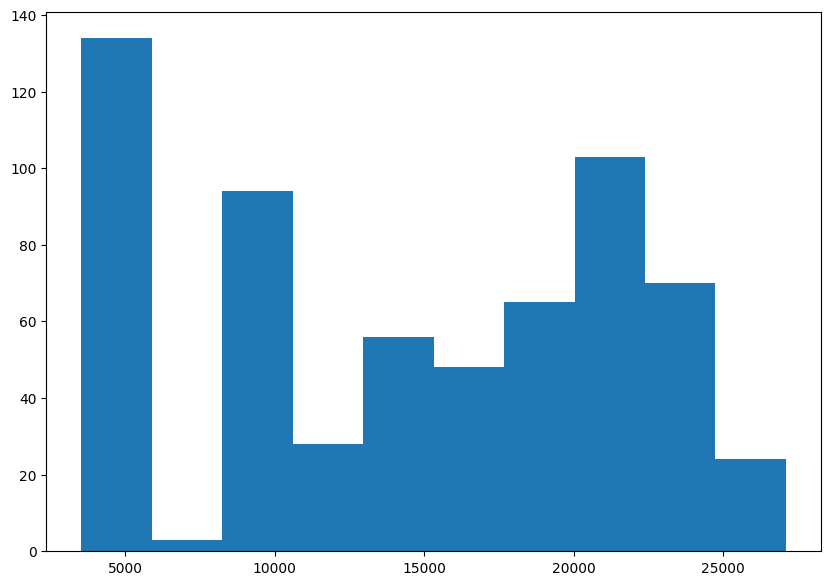

In [17]:
a = out_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

Save the Model as a .pt file

In [18]:
# os.chdir('../HMEI2023-bxliu-models/')
# save_file = 'cats.pt'
# torch.save(net.state_dict(), save_file)

Visually Representation of the Structure of the Model

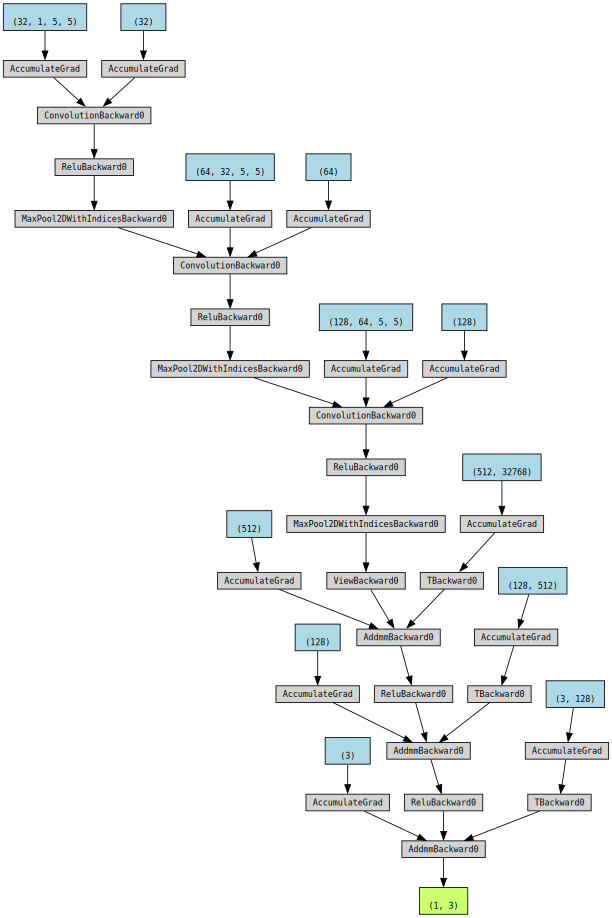

In [19]:
test_data = torch.rand(1,1,128,128)
test_net = ConvNet()
out = test_net.forward(test_data)
make_dot(out)

Next Steps:
custom loss function (later)
documentation (done)
validation (done-ish, needs going thru again with all the datasets probably)
more data (done)
graph outputs not just loss (done)
outside training set for 5by400 and 10by200 (done-ish)



4. Make a function that takes in image data and outputs the model's prediction

In [49]:
f = '../HMEI2023-bxliu-data/image_test/gentrain_131.png'
data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
data = np.expand_dims(data, axis=2)
print(data.shape)
# out = net.forward()

(128, 128, 1)


In [50]:
def use_net(im_data):
    l = []
    l.append(im_data)
    l = np.asarray(l)
    l = np.moveaxis(l, -1, 1)
    print(l.shape)
    l = torch.tensor(l).float()
    l = torch.div(l, 255).float()
    l = l.to(device)
    print(l.shape)
    print(l)
    print(l.stride())
    

    with torch.no_grad():  
        test_data = torch.rand(1,1,128,128).to(device)
        test_data[0] = l[0]
        print(test_data.shape)
        print(test_data)
        print(test_data.stride())
        out = net.forward(test_data)
        # out = net.forward(l)
        out = torch.add(torch.mul(out[0], tstd.to(device)), tmean.to(device))
        x = out.detach().cpu().numpy()
        x[0] = math.exp(x[0])
    return x

In [51]:
use_net(data)

(1, 1, 128, 128)
torch.Size([1, 1, 128, 128])
tensor([[[[0.5961, 0.5961, 0.4902,  ..., 0.5490, 0.6000, 0.6000],
          [0.5843, 0.5843, 0.4784,  ..., 0.5569, 0.6196, 0.6196],
          [0.7020, 0.7020, 0.5922,  ..., 0.4667, 0.4118, 0.4118],
          ...,
          [0.3490, 0.3490, 0.4627,  ..., 0.4039, 0.3176, 0.3176],
          [0.4784, 0.4784, 0.4510,  ..., 0.4353, 0.3373, 0.3373],
          [0.4745, 0.4745, 0.4471,  ..., 0.4314, 0.3294, 0.3294]]]],
       device='cuda:0')
(16384, 1, 128, 1)
torch.Size([1, 1, 128, 128])
tensor([[[[0.5961, 0.5961, 0.4902,  ..., 0.5490, 0.6000, 0.6000],
          [0.5843, 0.5843, 0.4784,  ..., 0.5569, 0.6196, 0.6196],
          [0.7020, 0.7020, 0.5922,  ..., 0.4667, 0.4118, 0.4118],
          ...,
          [0.3490, 0.3490, 0.4627,  ..., 0.4039, 0.3176, 0.3176],
          [0.4784, 0.4784, 0.4510,  ..., 0.4353, 0.3373, 0.3373],
          [0.4745, 0.4745, 0.4471,  ..., 0.4314, 0.3294, 0.3294]]]],
       device='cuda:0')
(16384, 16384, 128, 1)


array([2.69058440e+00, 8.10617998e-01, 1.22281953e+04])

In [52]:
matfile = '../HMEI2023-bxliu-data/value_test/gentrain_131.mat'
mat = scipy.io.loadmat(matfile)
print(mat['th0'][0])

[1.00e+00 7.50e-01 1.25e+04]
